## DC Bike Rental Project:
- Dataset:
     * [UCI capital bike sharing](https://archive.ics.uci.edu/ml/datasets/bike+sharing+dataset)
     * Number of rentals every hour for two years (2011 - 2013)  
     * 17379 rows and 15 features
        
-------------------------------------------------------------------------

- Business Goals:
   * Identify key features for increase total bike rentals 
   * Identify features for cases where casual users are more than registered users 
      * casual users: passes (day, week, month, 1 time payment)
      * registered users: repeat payments (day key, monthly, yearly) 
   * Look for time trends and seasonality 
     * Test out a forecast model
   * Allow better marketing strategy and more focused rental maintenance for more profit 

In [22]:
# import libraries
import itertools
from statsmodels.tsa.seasonal import seasonal_decompose
import warnings
import statsmodels.api as sm
from statsmodels.api import OLS
from sklearn.metrics import r2_score
from sklearn.linear_model import LassoCV, RidgeCV, LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split, cross_val_score
import helper_functions1 as hf
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
# import libraries
warnings.filterwarnings('ignore')

In [2]:
# load cleaned dataset for exploratory visualization
bikes_df = pd.read_pickle('cleaned_data/bikes_regression.pkl')

### column transformation and feature selections:  

* For details, see datacleaning notebook file 

- Drop instant columns as just index id  
- Convert dteday as datetime object and set as index for time series analysis
- Convert season, yr, mnth, holiday, weekday, workingday, weathersit to categorical value
   * Create one hot encoder (pd.dummy)
- Create a new column as more casual than register (compare value between 2 for logistic regression)
   * Remove casual and registered users 
- Remove atemp as it correlates with temp column 
- Remove month columns as it correlates with season column but not as correlated with target
- Perform np.log transformation for cnt and temp for normal distribution
- Perform cubic root transformation for hum column for normal distribution 

------------

### Linear Regression:
   * target: cnt 

### Logistic Regression:
   * target: 1 for when more casual users than registered users, otherwise 0 
   
### Time Series Analysis:
   * Identify monthly trend, seasonality, forecast model for the future 
   
-----

### visual exploratory data analysis

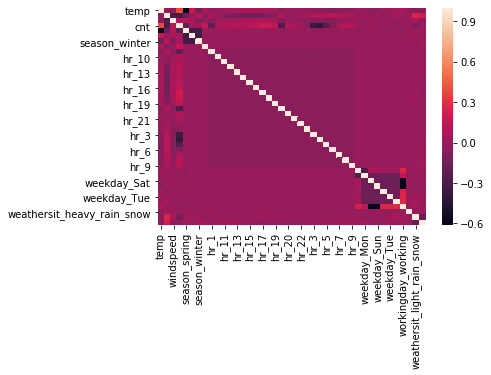

In [3]:
# correlation map
sns.heatmap(bikes_df.corr())

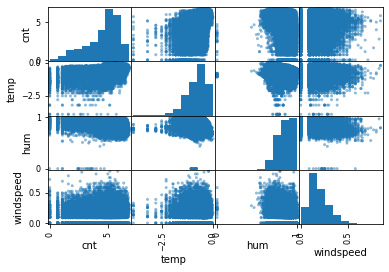

In [4]:
# due to too many columns, perform scatter matrix for numerical variables only
pd.plotting.scatter_matrix(bikes_df[['cnt', 'temp', 'hum', 'windspeed']])
plt.show()

### visualization insights:

* correlation heatmap: hr_1 to hr23 appear to have the most correlation with cnt 
* None of numeric variable appear to linearly correlate with cnt 

------

### Linear Regression

- target: cnt (total bike rentals (registered and casual users) 
- features: all remaining columns after cnt

-----

##### step1: split data into train and test 

In [8]:
# intialize bikes_df class
bikes = hf.BikeLinearRegression(bikes_df, 'cnt')
# Define target and x_cols
target, x_cols = bikes.target_features()
# split data into train and test, 20% test, 80% train
X_train, X_test, y_train, y_test = train_test_split(
    x_cols, target, test_size=0.2, random_state=42)

##### step2: perform linear regression using statsmodel and check for p-values
- stat1: keep all features even if p_values is > 0.05
- stat2: remove features with p_values > 0.05 

----

Stat1 Analyses:

- Adjusted R2 for train 
- R2 for test 
- top 10 most relevant features (based upon coef magnitude)
- 5 least impactful features( based upon coef magnitude)

adjusted R2: 0.8252264595608264
R2 for test: 0.8143355841672658


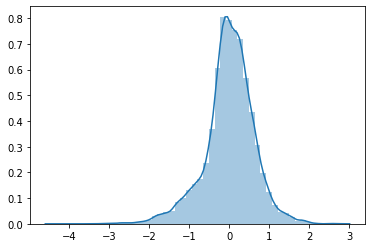

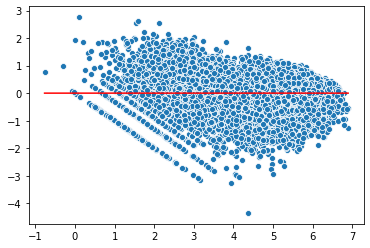

In [19]:
# stat1
results_stats = bikes.stats_models(X_train, y_train)
print('adjusted R2:', results_stats.rsquared_adj)
# check for predicted r2
print('R2 for test:', bikes.stats_pred(X_train, y_train, X_test, y_test))
# identify most relevant and least relevant features
top_10_stat1, bottom_5_stat1 = bikes.stats_top_bottom_features(
    X_train, y_train, 'stats1')
# check for normality and homoscedasticity
bikes.normality_homoscedasticity(X_train, y_train)

- Residual appears to be normally distributed 
- It appears to be random and the sharp edge is caused by cnt cut off point at 0 
- Both train and test seems to be have R2 around 0.82

----
Stat2 Analyses:

- Remove features with p_value > 0.05 
- adjusted R2 for train 
- R2 for test 
- Top 10 most relevant features (based upon coef magnitude)
- 5 least impactful features( based upon coef magnitude)


adjusted R2: 0.8252356100119762
R2 for test: 0.8144623167846345


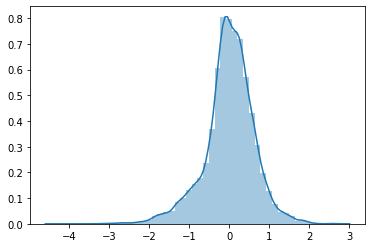

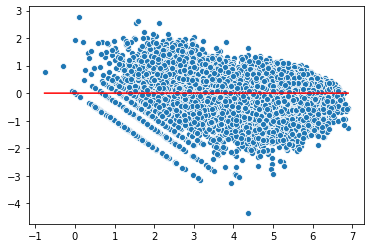

In [12]:
# remove high p value and see how it affects results
columns_high_p = results_stats.pvalues[results_stats.pvalues > 0.05].index
X_colsremoved = X_train.drop(columns=columns_high_p)
X_pred_colsremoved = X_test.drop(columns=columns_high_p)
# perform statsmodel linear regression
results_stats2 = bikes.stats_models(X_colsremoved, y_train)
print('adjusted R2:', results_stats2.rsquared_adj)
# predict on test set
print('R2 for test:', bikes.stats_pred(
    X_colsremoved, y_train, X_pred_colsremoved, y_test))
# find top 10 most relevant and 5 least relevant features
top_10_stat2, bottom_5_stat2 = bikes.stats_top_bottom_features(
    X_colsremoved, y_train, 'stats2')
# check for assumptions
bikes.normality_homoscedasticity(X_colsremoved, y_train)

- Residual appears to be normally distributed 
- It appears to be random and the sharp edge is caused by cnt cut off point at 0 
- Both train and test seems to be have R2 around 0.82
- Removing features with high p values didn't appear to affect R2 results 

----
### sklearn lassoCV, ridgeCV and LinearRegression with CV with different lambda values:
- Use cross validation of 10 to find best lambdas 
- Use r2 as metrics 
- Top 10 most relevant features (based upon coef magnitude)
- 5 least impactful features( based upon coef magnitude)
- Perform 10 fold linear regression cross validation 
   * average R2, average RMSE, average MAE

In [20]:
# ridge regression
ridge_top10, ridge_bottom5 = bikes.ridge_cv(X_train, y_train, X_test, y_test)
# lasso regression , make sure alphas
lasso_top10, lasso_bottom5 = bikes.lasso_cv(X_train, y_train, X_test, y_test)
# cross validation on linear regression model
print()
print('Linear regression with zero regularization:')
bikes.linear_cv()

best lambda: 0.2777777777777778
ridge_train: 0.8257271383065374
ridge_test: 0.8143812675009556
3.4e-05
lasso_train: 0.8257228773090868
lasso_test: 0.8144289213131726
features removed: 0

Linear regression with zero regularization:
MAE: 0.47060269568818686
RMSE: 0.6335976403096318
R2: 0.8005550113246647


,MAE,RMSE,r2
0,0.470603,0.633598,0.800555


- Both Lasso and Ridge appears to perform similarly well and they have similar R2 as stat1, stat2 
- Both Lasso and Ridge appears to perform better than zero regularizaiton
- Lasso regularizaiton removes zero features 

----
### Look at most relevant features and least relevant features 
- Use results from stat1, stat2, ridge and lasso because they all give similar R2 

,stats1,stats2,ridge,lasso
0,weathersit_mist,holiday_not_holiday,weathersit_mist,weekday_Sat
1,weekday_Sat,weathersit_mist,weekday_Sat,workingday_working
2,workingday_working,weekday_Sat,workingday_working,weathersit_mist
3,weekday_Sun,workingday_working,weekday_Sun,weekday_Sun
4,season_summer,weekday_Sun,season_summer,season_summer


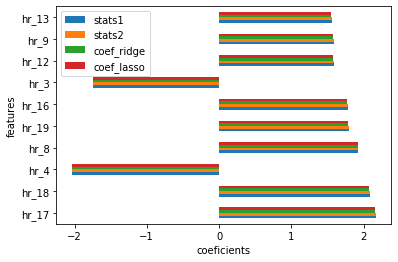

In [21]:
# merge all 4 model top features together
dfs_top_10 = [top_10_stat1, top_10_stat2, ridge_top10.set_index(
    'cols'), lasso_top10.set_index('cols')]
bikes_10 = bikes.merge_feature_dfs(dfs_top_10, plot=True)
# merge all 4 model bottom features together
bottom_5_stat1 = bottom_5_stat1.reset_index(
)[['index']].rename(columns={'index': 'stats1'})
bottom_5_stat2 = bottom_5_stat2.reset_index(
)[['index']].rename(columns={'index': 'stats2'})
ridge_5 = ridge_bottom5.reset_index()[['cols']].rename(
    columns={'cols': 'ridge'})
lasso_5 = lasso_bottom5.reset_index()[['cols']].rename(
    columns={'cols': 'lasso'})
bottom_5_dfs = [bottom_5_stat1, bottom_5_stat2, ridge_5, lasso_5]
bikes.merge_feature_dfs(bottom_5_dfs)

### Linear Regression Conclusions:

* All 4 models suggest:
   - rush hours(8-9am, 12-1pm, 4-7pm) increase total bike rentals
   - 3-4am decrease bike rentals
   - All agree on top 10 most relevant features 
   - All mostly agree that misty mild weatherday, weekend, working day, and summer season have least impact on bike rentals
   
----

### Logistic Regression: 

### Logistic Regression Conclusions:



----
### Time Series Analysis:
  - Identify monthly trend,seasonality, forecast model for the future

---

Decompose monthly sum into trend and seasonality 


<Figure size 432x288 with 0 Axes>

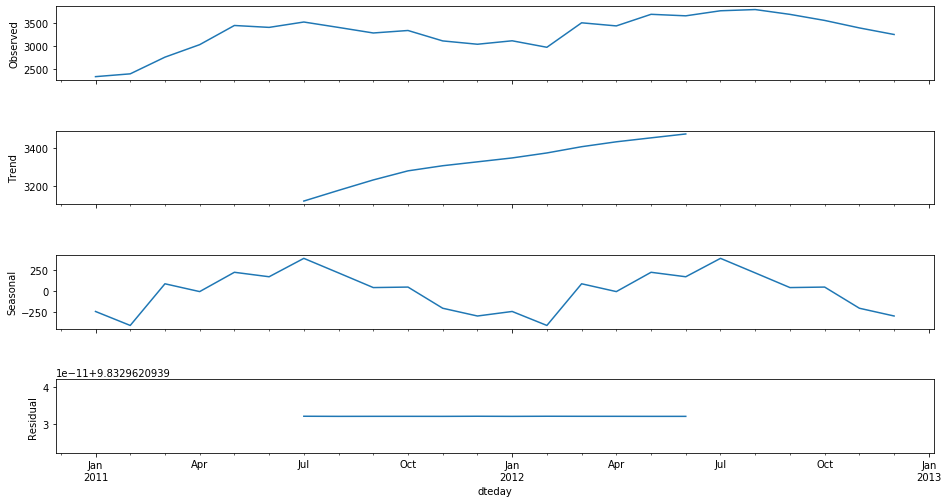

In [25]:
# initialize class
bikes_time = hf.TimeSeries(bikes_df, 'cnt')
# generate time series dataframe
bikes_time_df = bikes_time.create_timeseries()
# monthly rental (resample by month and take sum )
monthly_cnt = bikes_time.plot_time_monthly()
# decompose monthly_cnt into trend and seasonality
bikes_time.generate_decomp()

- Definitely an upward trend going from 2011 to 2013
- An obvious seasonality between 2011 to 2013:
   - Decreases during cold or hot weather (Jan to Feb, July to Sept, Oct to Dec)
   - Increases during mild weather (Feb to July, Sept to Oct)
----
### SARIMAX Forecast Model 
- Split dataset into 90% train and 10% test based upon order of dates 
- Create combos of pdq and pdqs for model tuning 
- Use the best combo to fit SARIMAX model
- Predict 10% test data and compare with actual test value 

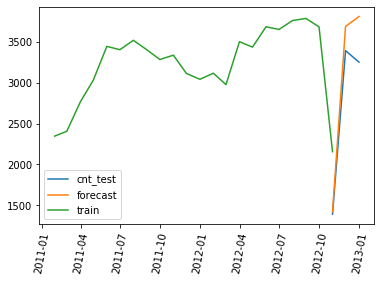

In [26]:
# create train, test
train, test = bikes_time.generate_train_test(bikes_time_df)
# create pdq, pdqs combos
pdq, pdqs = bikes_time.generate_combo()
# parameter tuning (warnings: this may take a while)
bikes_time.model_parameter_tuning(pdq, pdqs)
# get forecast
final_model = bikes_time.sarimax_model(train, (1, 0, 1), (1, 1, 1, 12))
pred = bikes_time.forecast(final_model, test)
# compare results
bikes_time.plot_finalresults(test, train)

- best tuning combo is (1,0,1),(1,1,1,12) 
- Final model did a great job forecast upward trend
- Due to limited data, the model fails to forecast downward trend going to colder weather 

----
### Time Series Analysis Conclusions:
- An obvious upward trend which indicates an increasing demand for bike rentals 
- Seasonality trend correponds to the weather 
- More data should be gathered to gain insights on how uber or lyft affect bike rentals 

---

## Final Conclusions:
  * Hours of the day appears to be the most important factor for total bike rentals and number of casual users 
  * Holiday and nice weather also correponds to more causal users than registered users 
  * AUC curve can be quite deceptive for rare events and high false positive rate is highly common in these cases 
  * We observe upward trend from 2011 to 2013 for bike rental demand 
  * Bike rental demand tends to decline during cold or hot weather and increase during mild months 

## Follow-ups:
  * Gather recent bike rental data and see how lyft and uber affect bike rentals in DC 
  * Extend data from other locations such as New York City, Chicago, California to see a trend beyond DC metro areas 
  * Find location information to allow marketing and bike rental maintenance focuses at specific rental centers 

---